In [9]:
import sys 
sys.path.append('../scripts/')
from robot_edit import *
from scipy.stats import multivariate_normal

In [10]:
class Particle:  ###beforeimpllikelihood
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更
        print(observation)

In [11]:
class Mcl:  ###recvmapmcl
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):    #2行目でenvmapを追加、3行目で標準偏差を追加
        self.particles = [Particle(init_pose, 1.0/num) for i in range(num)]
        self.map = envmap  #以下3行追加
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): 
        for p in self.particles: p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) #引数を追加
        
    def draw(self, ax, elems):         #次のように変更
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys, \
                               angles='xy', scale_units='xy', scale=1.5, color="blue", alpha=0.5)) #変更

In [12]:
class EstimationAgent(Agent):  ###recvmap (1-6行目) -> 不要に
    def __init__(self, time_interval, nu, omega, estimator): 
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)


<IPython.core.display.Javascript object>


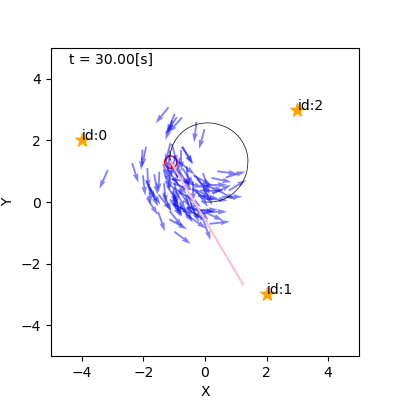

In [16]:
def trial(): ###addmap （12-15行目のみ）
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]: m.append_landmark(Landmark(*ln))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(m, initial_pose, 100) #地図mを渡す
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
trial()